[View in Colaboratory](https://colab.research.google.com/github/priyasin01/OBJECT-DETECTION-CLASSIFICATION-AND-SEGMENTATION/blob/master/Mask_R_CNN_Demo.ipynb)

#[How to run Object Detection and Segmentation on a Video Fast for Free](https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/)

## Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Install pycocotools

In [2]:
!pip install Cython

    100% |████████████████████████████████| 3.4MB 969kB/s 


In [3]:
!ls

sample_data


In [4]:
!git clone https://github.com/waleedka/coco

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.39 MiB | 5.36 MiB/s, done.
Resolving deltas: 100% (541/541), done.


In [5]:
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

    100% |████████████████████████████████| 573kB 8.1MB/s 
tensorflow 1.11.0rc1 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
  Found existing installation: setuptools 39.1.0
    Uninstalling setuptools-39.1.0:
      Successfully uninstalled setuptools-39.1.0
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.31.1)
make: Entering directory '/content/coco/PythonAPI'
# install pycocotools to the Python site-packages
python setup.py build_ext install
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.6-sXpGnM/python3.6-3.6.3=. -specs=/usr/share/dpkg/no-pie-compile.specs -fstack-p

## Git Clone the code

In [6]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Counting objects: 853, done.
remote: Total 853 (delta 0), reused 0 (delta 0), pack-reused 852
Receiving objects: 100% (853/853), 113.08 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (497/497), done.


## cd to the code directory and optionally download the weights file

In [7]:
import os
os.chdir('./Mask_RCNN')
!git checkout 555126ee899a144ceff09e90b5b2cf46c321200c
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Note: checking out '555126ee899a144ceff09e90b5b2cf46c321200c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 555126e... Balloon Color Splash sample.

Redirecting output to ‘wget-log’.


In [8]:
!ls

assets	    inspect_data.ipynb	   model.py	      train_shapes.ipynb
coco.py     inspect_model.ipynb    parallel_model.py  utils.py
config.py   inspect_weights.ipynb  README.md	      visualize.py
demo.ipynb  LICENSE		   samples	      wget-log
images	    mask_rcnn_coco.h5	   shapes.py


# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [10]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

## Create Model and Load Trained Weights

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


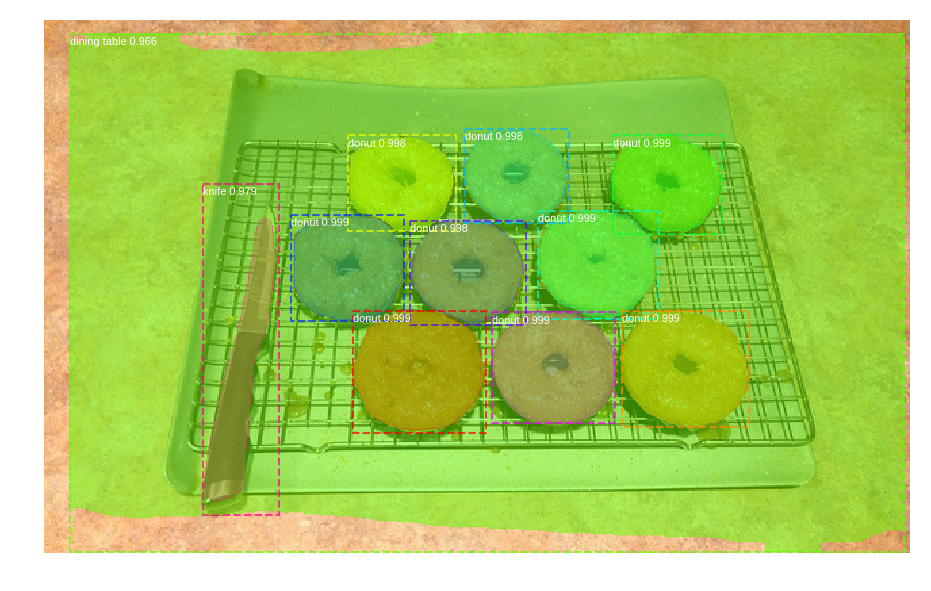

In [13]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


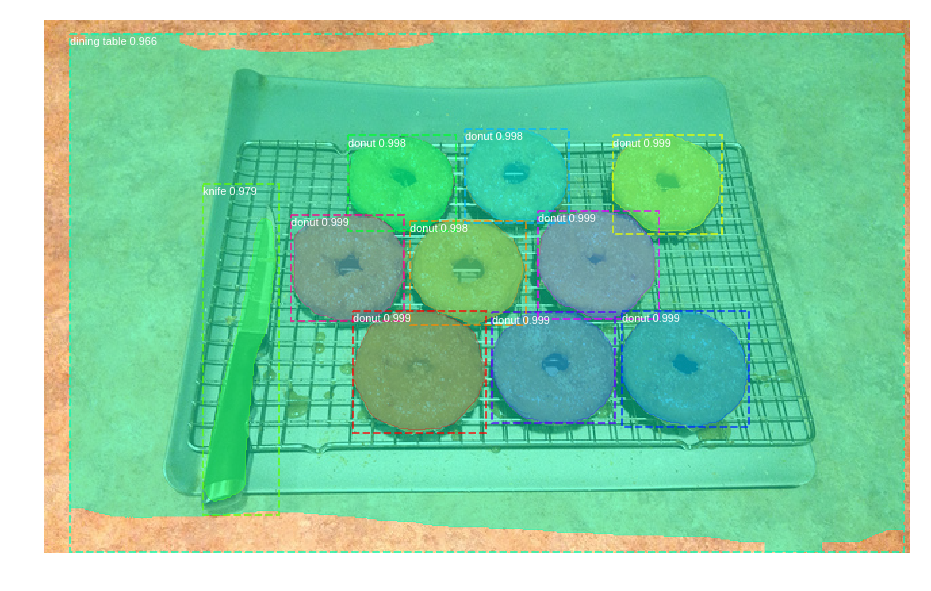

In [14]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, '8734543718_37f6b8bd45_z.jpg'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Custom image
You can upload an image to a third party website like

*   [imgbb](https://imgbb.com/)
*   [GitHub](https://github.com) repo raw image

Then download the image url here with `wget`.

We will also introduce using Google drive with Colab in the later section.

In [15]:
!wget https://preview.ibb.co/cubifS/sh_expo.jpg -P ./images


Redirecting output to ‘wget-log.1’.


Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


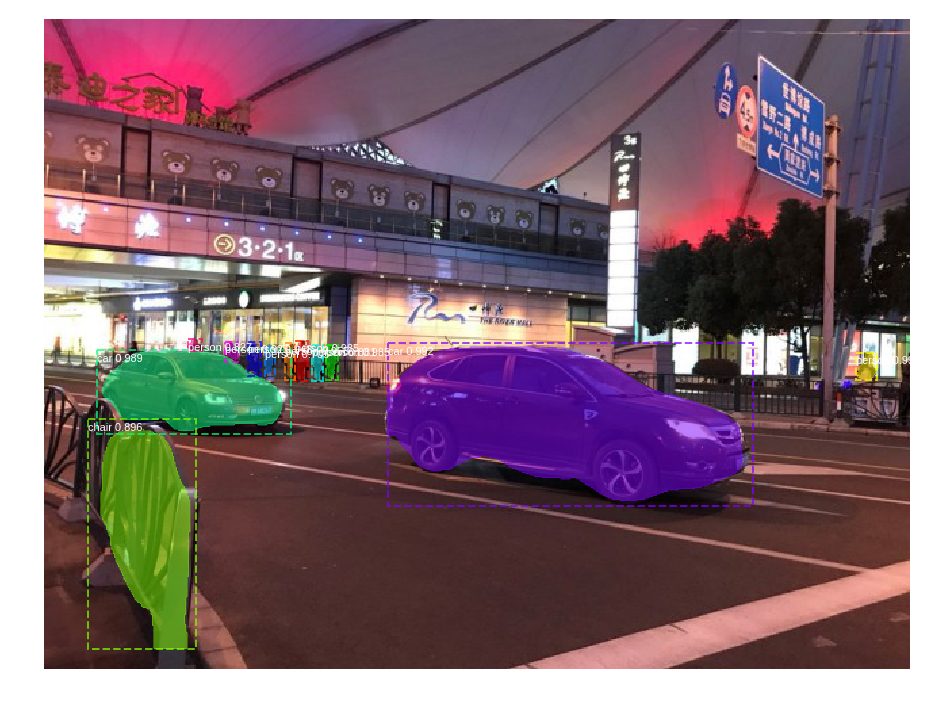

In [16]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, 'sh_expo.jpg'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Process Video
Download the video mp4 file.

In [17]:

!mkdir videos
!wget https://github.com/Tony607/blog_statics/releases/download/v1.0/trailer1.mp4 -P ./videos


Redirecting output to ‘wget-log.2’.


In [18]:
!ls ./videos

trailer1.mp4


In [19]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    import coco
    import utils
    import model as modellib
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3

    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'trailer1.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Predicted
NO INSTANCES TO DISPLAY
writing to file:/content/Mask_RCNN/videos/save/0.jpg
writing to file:/content/Mask_RCNN/videos/save/1.jpg
NO INSTANCES TO DISPLAY
writing to file:/content/Mask_RCNN/videos/save/2.jpg
frame_count :4
frame_count :5
frame_count :6
Predicted
NO INSTANCES TO DISPLAY
writing to file:/content/Mask_RCNN/videos/save/3.jpg
writing to file:/content/Mask_RCNN/videos/save/4.jpg
writing to file:/content/Mask_RCNN/videos/save/5.jpg
frame_count :7
frame_count :8
frame_count :9
Predicted
writing to file:/content/Mask_RCNN/videos/save/6.jpg
writing to file:/content/Mask_RCNN/videos/save/7.jpg
writing to file:/content/Mask_RCNN/videos/save/8.jpg
frame_count :10
frame_count :11
frame_count :12
Predicted
writing to file:/content/Mask_RCNN/videos/save/9.jpg
writing to file:/content/Mask_RCNN/videos/save/10.jpg
writing to file:/content/Mask_RCNN/videos/save/11.jpg
frame_count :13
frame_count :14
frame_count :15
Predicted
writing to file:/content/Mask_RCNN/videos/save/12.jpg


In [20]:
!ls ./videos/save

0.jpg	 179.jpg  257.jpg  335.jpg  413.jpg  492.jpg  570.jpg  649.jpg	727.jpg
100.jpg  17.jpg   258.jpg  336.jpg  414.jpg  493.jpg  571.jpg  64.jpg	728.jpg
101.jpg  180.jpg  259.jpg  337.jpg  415.jpg  494.jpg  572.jpg  650.jpg	729.jpg
102.jpg  181.jpg  25.jpg   338.jpg  416.jpg  495.jpg  573.jpg  651.jpg	72.jpg
103.jpg  182.jpg  260.jpg  339.jpg  417.jpg  496.jpg  574.jpg  652.jpg	730.jpg
104.jpg  183.jpg  261.jpg  33.jpg   418.jpg  497.jpg  575.jpg  653.jpg	731.jpg
105.jpg  184.jpg  262.jpg  340.jpg  419.jpg  498.jpg  576.jpg  654.jpg	732.jpg
106.jpg  185.jpg  263.jpg  341.jpg  41.jpg   499.jpg  577.jpg  655.jpg	733.jpg
107.jpg  186.jpg  264.jpg  342.jpg  420.jpg  49.jpg   578.jpg  656.jpg	734.jpg
108.jpg  187.jpg  265.jpg  343.jpg  421.jpg  4.jpg    579.jpg  657.jpg	735.jpg
109.jpg  188.jpg  266.jpg  344.jpg  422.jpg  500.jpg  57.jpg   658.jpg	736.jpg
10.jpg	 189.jpg  267.jpg  345.jpg  423.jpg  501.jpg  580.jpg  659.jpg	737.jpg
110.jpg  18.jpg   268.jpg  346.jpg  424.jpg  502.jpg  581

In [21]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'trailer1.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0


In [22]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7f5b523720b0>

In [23]:
!ls -alh ./videos/

total 63M
drwxr-xr-x 3 root root 4.0K Sep 25 15:14 .
drwxr-xr-x 8 root root 4.0K Sep 25 15:00 ..
-rw-r--r-- 1 root root  44M Sep 25 15:14 out.mp4
drwxr-xr-x 2 root root  20K Sep 25 15:13 save
-rw-r--r-- 1 root root  20M Mar 25  2018 trailer1.mp4


### Downlod the output video to our local machine

In [24]:
from google.colab import files
files.download('videos/out.mp4')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 43832, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [25]:
!ls

assets		    inspect_model.ipynb    __pycache__	       videos
coco.py		    inspect_weights.ipynb  README.md	       visualize.py
config.py	    LICENSE		   samples	       wget-log
demo.ipynb	    mask_rcnn_coco.h5	   shapes.py	       wget-log.1
images		    model.py		   train_shapes.ipynb  wget-log.2
inspect_data.ipynb  parallel_model.py	   utils.py
